# Определение перспективного тарифа для мобильного оператора

Мы трудимся в отделе аналитики мобильного операотра «Y-mobile». Клиентам собираются предложить два тарифных плана: «Смарт» и «Ультра». Коммерческий департамент хочет понять, какой тариф прибыльнее, чтобы скорректировать рекламный бюджет.

Нам нужно сделать предварительный анализ тарифов на небольшой выборке. Мы располагаем данными 500 пользователей. Необходимо проанализировать данные клиентов и понять, какой тариф может принести больше выручки.

**Описание тарифов**

**Тариф «Смарт»**

 - Ежемесячная плата: 550 рублей
 - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
 
Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

 - Ежемесячная плата: 1950 рублей
 - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
 
Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

Обратим внимание: оператор всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

**Содержание проекта**
- [Шаг 1. Общая информация о данных](#Шаг-1.-Общая-информация-о-данных)
- [Шаг 2. Подготовка данных](#Шаг-2.-Подготовка-данных)
 - [2.1 Приведение данных к нужным типам и исправление ошибок](#2.1-Приведение-данных-к-нужным-типам-и-исправление-ошибок)
 - [2.2 Расчет показателей для каждого пользователя](#2.2-Расчет-показателей-для-каждого-пользователя)
 - [2.3 Расчет выручки по абоненту за месяц](#2.3-Расчет-выручки-по-абоненту-за-месяц)
- [Шаг 3. Анализ данных](#Шаг-3.-Анализ-данных)
 - [3.1 Анализ абонентов тарифа smart](#3.1-Анализ-абонентов-тарифа-smart)
 - [3.2 Анализ абонентов тарифа ultra](#3.2-Анализ-абонентов-тарифа-ultra)
- [Шаг 4. Проверка гипотез](#Шаг-4.-Проверка-гипотез)
 - [4.1 Сравнение средней выручки пользователей тарифов smart и ultra](#4.1-Сравнение-средней-выручки-пользователей-тарифов-smart-и-ultra)
 - [4.2 Сравнение средней выручки пользователей из Москвы и других регионов](#4.2-Сравнение-средней-выручки-пользователей-из-Москвы-и-других-регионов)
- [Шаг 5. Общий вывод](#Шаг-5.-Общий-вывод)

**Описание данных**

Таблица users (информация о пользователях):

 - user_id — уникальный идентификатор пользователя
 - first_name — имя пользователя
 - last_name — фамилия пользователя
 - age — возраст пользователя (годы)
 - reg_date — дата подключения тарифа (день, месяц, год)
 - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
 - city — город проживания пользователя
 - tariff — название тарифного плана
 
Таблица calls (информация о звонках):

 - id — уникальный номер звонка
 - call_date — дата звонка
 - duration — длительность звонка в минутах
 - user_id — идентификатор пользователя, сделавшего звонок
 
Таблица messages (информация о сообщениях):

 - id — уникальный номер сообщения
 - message_date — дата сообщения
 - user_id — идентификатор пользователя, отправившего сообщение
 
Таблица internet (информация об интернет-сессиях):

 - id — уникальный номер сессии
 - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
 - session_date — дата интернет-сессии
 - user_id — идентификатор пользователя
 
Таблица tariffs (информация о тарифах):

 - tariff_name — название тарифа
 - rub_monthly_fee — ежемесячная абонентская плата в рублях
 - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
 - messages_included — количество сообщений в месяц, включённых в абонентскую плату
 - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
 - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг 1. Общая информация о данных

Итак, приступим к изучению данных. Начнем по очереди загружать датасеты и применять к ним методы info() и describe().

In [1]:
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st


Начнем с информации о пользователях, датасет users.

In [2]:
users = pd.read_csv('/datasets/users.csv')

In [3]:
users.head(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Поскольку столбец с индексом и user_id несут в себе уникальную характеристику, то можно индексом этой таблицы установить user_id.

In [4]:
users = users.set_index('user_id')
users.head()

,age,churn_date,city,first_name,last_name,reg_date,tariff
user_id,,,,,,,
1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         500 non-null    int64 
 1   churn_date  38 non-null     object
 2   city        500 non-null    object
 3   first_name  500 non-null    object
 4   last_name   500 non-null    object
 5   reg_date    500 non-null    object
 6   tariff      500 non-null    object
dtypes: int64(1), object(6)
memory usage: 31.2+ KB


In [6]:
users.describe()

,age
count,500.00000
mean,46.58800
std,16.66763
min,18.00000
25%,32.00000
50%,46.00000
75%,62.00000
max,75.00000


В столбце churn_date (дата прекращения пользования тарифом) есть пропуски. В дальнейшем, возможно стоит от них избавиться.

Далее изучим информацию о звонках, датасет calls.

In [7]:
calls = pd.read_csv('/datasets/calls.csv')

In [8]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [10]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Пропусков нет.

Далее изучим информацию о сообщениях, датасет messages.

In [11]:
messages = pd.read_csv('/datasets/messages.csv')

In [12]:
messages.head(5)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [14]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


В данных о сообщениях также пропусков нет.

Проанализируем данные об интернет-сессиях. Датасет internet.

In [15]:
internet = pd.read_csv('/datasets/internet.csv')

In [16]:
internet.head(5)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [18]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


В данном датасете мы видим возможное дублирование столбца индекса в столбце Unnamed: 0.

Вернемся к этому на следующем шаге.

Далее изучим информацию о тарифах, датасет tariffs.

In [19]:
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [20]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [21]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


## Шаг 2. Подготовка данных

### 2.1 Приведение данных к нужным типам и исправление ошибок

Прежде чем изменить типы данных, проверим таблицы на наличие дубликатов, для этого напишем цикл.

In [22]:
dfs = [users, messages, internet, calls]

for df in dfs:
    dups = df[df.duplicated()]
    print(dups)

Empty DataFrame
Columns: [age, churn_date, city, first_name, last_name, reg_date, tariff]
Index: []
Empty DataFrame
Columns: [id, message_date, user_id]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, id, mb_used, session_date, user_id]
Index: []
Empty DataFrame
Columns: [id, call_date, duration, user_id]
Index: []


Результатом цикла стало 4 пустых датафрейма, значит, дубликатов нет.

При изучении данных было змечено, что даты в формате 'object', значит, их нужно привести к формату datetime

In [23]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Вернемся к таблице internet на предмет дубликата столбца

In [24]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Проверим так ли этом перезагрузкой столбца с индексами и сравнением со столбцом 'Unnamed:0'

In [25]:
internet = internet.reset_index()

In [26]:
len (internet['index'] == internet['Unnamed: 0'])

149396

Получилось, что в столбце сравнения 14936 значений True, значит, эти столбцы идентичны и их можно удалить.

In [27]:
internet = internet.drop(columns=['index', 'Unnamed: 0'])

Таблица выглядит корректно.

In [28]:
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [29]:
internet.tail(10)

,id,mb_used,session_date,user_id
149386,1499_147,0.00,2018-10-21,1499
149387,1499_148,268.19,2018-11-13,1499
149388,1499_149,778.68,2018-11-24,1499
149389,1499_150,273.98,2018-11-20,1499
149390,1499_151,752.72,2018-10-11,1499
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499
149395,1499_156,544.37,2018-10-26,1499


Далее нужно определиться, как поступить со звонками, длительность которых составляет 0 минут 0 секунд.

Узнаем, сколько их.

In [30]:
calls['duration'].value_counts()

0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64

Получается, что около 40000 имели длительность 0. Это примерно около 20% всех звонков. Если предположить, что это были исходящие пропущенные звонки, то доля около 20% интуитивно кажется нормальной. То есть, грубо, на каждый пятый звонок абонента не отвечают.

Пока примем для себя, что это пропущенные звонки и удалять их не будем.

### 2.2 Расчет показателей для каждого пользователя

Итак, тарификация в тарифах идет по минутам и мегабайтам. При этом оператор всегда округляет такие значения вверх до целого.

Значит, нам необходимо избавиться от десятичных знаков в столбцах 'использованные мегабайты' таблицы internet и  'длительность звонков' таблицы calls.

Приводить к целым значениям и избавляться от дробной части будем методом  .ceil библиотеки math.

In [31]:
internet['mb_used'] = internet['mb_used'].apply(mt.ceil)
calls['duration'] = calls['duration'].apply(mt.ceil)

In [32]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  int64         
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.6+ MB


Как видим, тип данных изменился на целочисленный.

Нам нужны данные по месяцам, поэтому добавим столбец 'month' во все интересующие нас таблицы: calls, internet, messages.

In [33]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month

Проверим на примере calls.

In [34]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Столбец добавился корректно.

Теперь создадим сводную таблицу, в которой сгруппируем данные по id пользователя и месяцу, чтобы узнать количество звонков в месяц и суммарную продолжительность звонков в месяц.

In [35]:
calls_by_month = calls.pivot_table(index=('user_id', 'month'), values = 'duration', aggfunc = ['count', 'sum'])
calls_by_month.head(10)

count      sum
              duration duration
user_id month                  
1000    5           22      159
        6           43      172
        7           47      340
        8           52      408
        9           58      466
        10          57      350
        11          43      338
        12          46      333
1001    11          59      430
        12          63      414

Переименуем столбцы

In [36]:
calls_by_month.columns = ['calls_month_count', 'calls_month_duration']
calls_by_month.head(10)

calls_month_count  calls_month_duration
user_id month                                         
1000    5                     22                   159
        6                     43                   172
        7                     47                   340
        8                     52                   408
        9                     58                   466
        10                    57                   350
        11                    43                   338
        12                    46                   333
1001    11                    59                   430
        12                    63                   414

Далее создадим сводную таблицу для подсчета отправленных сообщений по месяцам.

In [37]:
messages_by_month = messages.pivot_table(index=('user_id', 'month'), values = 'id', aggfunc = 'count')
messages_by_month.head(10)

id
user_id month    
1000    5      22
        6      60
        7      75
        8      81
        9      57
        10     73
        11     58
        12     70
1002    6       4
        7      11

Переименуем столбец.

In [38]:
messages_by_month.columns = ['messages_month_count']
messages_by_month.head(10)

messages_month_count
user_id month                      
1000    5                        22
        6                        60
        7                        75
        8                        81
        9                        57
        10                       73
        11                       58
        12                       70
1002    6                         4
        7                        11

Далее создадим сводную таблицу для расчета использованию интернет-трафика каждым пользователем по месяцам.

In [39]:
internet_by_month = internet.pivot_table(index=('user_id', 'month'), values = 'mb_used', aggfunc = ['sum'])
internet_by_month.head(10)

sum
              mb_used
user_id month        
1000    5        2256
        6       23257
        7       14016
        8       14070
        9       14581
        10      14717
        11      14768
        12       9827
1001    11      18452
        12      14053

Переименуем столбец

In [40]:
internet_by_month.columns = ['internet_monthly_usage']
internet_by_month.head(10)

internet_monthly_usage
user_id month                        
1000    5                        2256
        6                       23257
        7                       14016
        8                       14070
        9                       14581
        10                      14717
        11                      14768
        12                       9827
1001    11                      18452
        12                      14053

Далее объединим все месячные данные в одну таблицу.

Применим метод join.

In [41]:
monthly_data = calls_by_month.join([messages_by_month, internet_by_month])
monthly_data.head(15)

calls_month_count  calls_month_duration  messages_month_count  \
user_id month                                                                  
1000    5                   22.0                 159.0                  22.0   
        6                   43.0                 172.0                  60.0   
        7                   47.0                 340.0                  75.0   
        8                   52.0                 408.0                  81.0   
        9                   58.0                 466.0                  57.0   
        10                  57.0                 350.0                  73.0   
        11                  43.0                 338.0                  58.0   
        12                  46.0                 333.0                  70.0   
1001    11                  59.0                 430.0                   NaN   
        12                  63.0                 414.0                   NaN   
1002    6                   15.0                 117.0                   4.0   
        7                   26.0                 214.0                  11.0   
        8                   42.0                 289.0                  13.0   
        9                   36.0                 206.0                   4.0   
        10                  33.0                 212.0                  10.0   

               internet_monthly_usage  
user_id month                          
1000    5                      2256.0  
        6                     23257.0  
        7                     14016.0  
        8                     14070.0  
        9                     14581.0  
        10                    14717.0  
        11                    14768.0  
        12                     9827.0  
1001    11                    18452.0  
        12                    14053.0  
1002    6                     10871.0  
        7                     17601.0  
        8                     20347.0  
        9                     16712.0  
        10                    13905.0

Добавим информацию о тарифах и городе по каждому пользователю. Применим также метод join.

In [42]:
monthly_data = monthly_data.join(users[['tariff', 'city']])

In [43]:
monthly_data.head(15)

calls_month_count  calls_month_duration  messages_month_count  \
user_id month                                                                  
1000    5                   22.0                 159.0                  22.0   
        6                   43.0                 172.0                  60.0   
        7                   47.0                 340.0                  75.0   
        8                   52.0                 408.0                  81.0   
        9                   58.0                 466.0                  57.0   
        10                  57.0                 350.0                  73.0   
        11                  43.0                 338.0                  58.0   
        12                  46.0                 333.0                  70.0   
1001    11                  59.0                 430.0                   NaN   
        12                  63.0                 414.0                   NaN   
1002    6                   15.0                 117.0                   4.0   
        7                   26.0                 214.0                  11.0   
        8                   42.0                 289.0                  13.0   
        9                   36.0                 206.0                   4.0   
        10                  33.0                 212.0                  10.0   

               internet_monthly_usage tariff         city  
user_id month                                              
1000    5                      2256.0  ultra    Краснодар  
        6                     23257.0  ultra    Краснодар  
        7                     14016.0  ultra    Краснодар  
        8                     14070.0  ultra    Краснодар  
        9                     14581.0  ultra    Краснодар  
        10                    14717.0  ultra    Краснодар  
        11                    14768.0  ultra    Краснодар  
        12                     9827.0  ultra    Краснодар  
1001    11                    18452.0  smart       Москва  
        12                    14053.0  smart       Москва  
1002    6                     10871.0  smart  Стерлитамак  
        7                     17601.0  smart  Стерлитамак  
        8                     20347.0  smart  Стерлитамак  
        9                     16712.0  smart  Стерлитамак  
        10                    13905.0  smart  Стерлитамак

In [44]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calls_month_count       3174 non-null   float64
 1   calls_month_duration    3174 non-null   float64
 2   messages_month_count    2678 non-null   float64
 3   internet_monthly_usage  3163 non-null   float64
 4   tariff                  3174 non-null   object 
 5   city                    3174 non-null   object 
dtypes: float64(4), object(2)
memory usage: 342.4+ KB


Из информации выше, мы видим, что в таблице есть пропуски - абоненты, которые не отправляли сообщения и не пользовались интернетом. В таком случае заменим пропуски нулями.

In [81]:
f'Количество пользователей: {monthly_data.reset_index().user_id.nunique()}'

'Количество пользователей: 492'

In [45]:
monthly_data['messages_month_count'] = monthly_data['messages_month_count'].fillna(0)
monthly_data['internet_monthly_usage'] = monthly_data['internet_monthly_usage'].fillna(0)

In [46]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calls_month_count       3174 non-null   float64
 1   calls_month_duration    3174 non-null   float64
 2   messages_month_count    3174 non-null   float64
 3   internet_monthly_usage  3174 non-null   float64
 4   tariff                  3174 non-null   object 
 5   city                    3174 non-null   object 
dtypes: float64(4), object(2)
memory usage: 342.4+ KB


Теперь заменим тип данных с float на целочисленный.

In [47]:
monthly_data[['calls_month_count', 'calls_month_duration', 
              'messages_month_count','internet_monthly_usage']] = monthly_data[['calls_month_count', 
                        'calls_month_duration', 'messages_month_count','internet_monthly_usage']].astype('int')

In [48]:
monthly_data.head(15)

calls_month_count  calls_month_duration  messages_month_count  \
user_id month                                                                  
1000    5                     22                   159                    22   
        6                     43                   172                    60   
        7                     47                   340                    75   
        8                     52                   408                    81   
        9                     58                   466                    57   
        10                    57                   350                    73   
        11                    43                   338                    58   
        12                    46                   333                    70   
1001    11                    59                   430                     0   
        12                    63                   414                     0   
1002    6                     15                   117                     4   
        7                     26                   214                    11   
        8                     42                   289                    13   
        9                     36                   206                     4   
        10                    33                   212                    10   

               internet_monthly_usage tariff         city  
user_id month                                              
1000    5                        2256  ultra    Краснодар  
        6                       23257  ultra    Краснодар  
        7                       14016  ultra    Краснодар  
        8                       14070  ultra    Краснодар  
        9                       14581  ultra    Краснодар  
        10                      14717  ultra    Краснодар  
        11                      14768  ultra    Краснодар  
        12                       9827  ultra    Краснодар  
1001    11                      18452  smart       Москва  
        12                      14053  smart       Москва  
1002    6                       10871  smart  Стерлитамак  
        7                       17601  smart  Стерлитамак  
        8                       20347  smart  Стерлитамак  
        9                       16712  smart  Стерлитамак  
        10                      13905  smart  Стерлитамак

In [49]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   calls_month_count       3174 non-null   int64 
 1   calls_month_duration    3174 non-null   int64 
 2   messages_month_count    3174 non-null   int64 
 3   internet_monthly_usage  3174 non-null   int64 
 4   tariff                  3174 non-null   object
 5   city                    3174 non-null   object
dtypes: int64(4), object(2)
memory usage: 342.4+ KB


### 2.3 Расчет выручки по абоненту за месяц

Итак, вызовем таблицу с информацией о тарифах

In [50]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Итак, у нас 2 тарифа. Мы используем информацию из этой таблицы для написания функции расчета месячной выручки.

In [51]:
# напишем функцию для строки
# она будет принимать строку и проверять какой вид тарифа и пользователя
# в зависимости от тарифа будет производиться соответствующие вычисления

def revenue_in_month(row):
    tariff = row['tariff']
    messages = row['messages_month_count']
    internet_mb = row['internet_monthly_usage']
    minutes = row['calls_month_duration']
    
    # здесь запишем абонентскую плату по тарифам
    
    smart_fee = 550
    ultra_fee = 1950
    
    # проверим, является ли тариф smart
    
    if tariff == 'smart':
        # если да - то начинаем считать использованные сообщения, минуты и мегабайты
        # сверх включенного в тариф объема
        # если лимит не был потрачен, то в extra сохраняем ноль
        # если вышли за пределы  - то берем превышение по модулю
        
        if 50 - messages > 0:
            extra_messages = 0
        else:
            extra_messages = abs(50 - messages)
        if 500 - minutes > 0:
             extra_minutes = 0
        else:
             extra_minutes = abs(500 - minutes)
        if 15360 - internet_mb > 0:
            extra_internet_mb = 0
        else:
            extra_internet_mb = abs(15360 - internet_mb)
            
        # здесь умножаем экстра-объем на соответствующие тарифу цены
        # количество интернет трафика в мб переводим в гб и округляем вверх
        # затем прибавляем абонентскую плату
        
        monthly_revenue = (extra_messages * 3 + extra_minutes * 3 + 
        mt.ceil(extra_internet_mb / 1024) * 200 + smart_fee)
            
        return monthly_revenue
    
    # здесь проводим вычисления для тарифа ultra
    
    else:
        if 1000 - messages > 0:
            extra_messages = 0
        else:
            extra_messages = abs(1000 - messages)
        if 3000 - minutes > 0:
             extra_minutes = 0
        else:
             extra_minutes = abs(3000 - minutes)
        if 30720 - internet_mb > 0:
            extra_internet_mb = 0
        else:
            extra_internet_mb = abs(30720 - internet_mb)
        
        monthly_revenue = (extra_messages * 1 + extra_minutes * 1 + 
        mt.ceil(extra_internet_mb / 1024) * 150 + ultra_fee)
            
        return monthly_revenue     

Добавляем новый столбец, применяя написанную формулу к строке.

In [52]:
monthly_data['monthly_revenue'] = monthly_data.apply(revenue_in_month, axis = 1)

In [53]:
monthly_data.head(20)

calls_month_count  calls_month_duration  messages_month_count  \
user_id month                                                                  
1000    5                     22                   159                    22   
        6                     43                   172                    60   
        7                     47                   340                    75   
        8                     52                   408                    81   
        9                     58                   466                    57   
        10                    57                   350                    73   
        11                    43                   338                    58   
        12                    46                   333                    70   
1001    11                    59                   430                     0   
        12                    63                   414                     0   
1002    6                     15                   117                     4   
        7                     26                   214                    11   
        8                     42                   289                    13   
        9                     36                   206                     4   
        10                    33                   212                    10   
        11                    32                   243                    16   
        12                    33                   236                    12   
1003    8                     55                   380                    37   
        9                    134                   961                    91   
        10                   108                   855                    83   

               internet_monthly_usage tariff         city  monthly_revenue  
user_id month                                                               
1000    5                        2256  ultra    Краснодар             1950  
        6                       23257  ultra    Краснодар             1950  
        7                       14016  ultra    Краснодар             1950  
        8                       14070  ultra    Краснодар             1950  
        9                       14581  ultra    Краснодар             1950  
        10                      14717  ultra    Краснодар             1950  
        11                      14768  ultra    Краснодар             1950  
        12                       9827  ultra    Краснодар             1950  
1001    11                      18452  smart       Москва             1350  
        12                      14053  smart       Москва              550  
1002    6                       10871  smart  Стерлитамак              550  
        7                       17601  smart  Стерлитамак             1150  
        8                       20347  smart  Стерлитамак             1550  
        9                       16712  smart  Стерлитамак              950  
        10                      13905  smart  Стерлитамак              550  
        11                      18610  smart  Стерлитамак             1350  
        12                      18137  smart  Стерлитамак             1150  
1003    8                        8571  ultra       Москва             1950  
        9                       12479  ultra       Москва             1950  
        10                      14779  ultra       Москва             1950

Узнаем, сколько у нас месяцев, соответствующих тарифу ultra и сколько - smart.

In [54]:
monthly_data['tariff'].value_counts()

smart    2223
ultra     951
Name: tariff, dtype: int64

Количество доступных данных по абонентам smart более чем в 2 раза превышает доступные данные по абонентам ultra.

### Вывод 

Итак, на этом этапе мы сгруппировали данные по пользователям и месяцам, посчитав количество звоноков в минутах в месяц, сообщений в месяц, потраченных мегабайтов интернета в месяц.

Затем мы объединили полученные данные в большой датафрейм - monthly_data.

После этого написали формулу для расчета выручки в месяц и применили ее к строке, получив необходимые значения.

На следующем этапе проанализируем полученные данные.



## Шаг 3. Анализ данных

Начнем анализировать то, как пользуются услугами абоненты двух тарифных групп.

Для этого создадим отдельные таблицы, в которых будут абоненты только одного тарифа.

Начнем с тарифа smart.

### 3.1 Анализ абонентов тарифа smart

In [55]:
monthly_data_smart = monthly_data.query('tariff == "smart"')
monthly_data_smart.head(15)

calls_month_count  calls_month_duration  messages_month_count  \
user_id month                                                                  
1001    11                    59                   430                     0   
        12                    63                   414                     0   
1002    6                     15                   117                     4   
        7                     26                   214                    11   
        8                     42                   289                    13   
        9                     36                   206                     4   
        10                    33                   212                    10   
        11                    32                   243                    16   
        12                    33                   236                    12   
1005    1                     15                    95                     7   
        2                     69                   456                    38   
        3                     77                   606                    56   
        4                    101                   712                    41   
        5                     73                   595                    42   
        6                     80                   612                    47   

               internet_monthly_usage tariff              city  \
user_id month                                                    
1001    11                      18452  smart            Москва   
        12                      14053  smart            Москва   
1002    6                       10871  smart       Стерлитамак   
        7                       17601  smart       Стерлитамак   
        8                       20347  smart       Стерлитамак   
        9                       16712  smart       Стерлитамак   
        10                      13905  smart       Стерлитамак   
        11                      18610  smart       Стерлитамак   
        12                      18137  smart       Стерлитамак   
1005    1                        2730  smart  Набережные Челны   
        2                        7394  smart  Набережные Челны   
        3                       11117  smart  Набережные Челны   
        4                        9365  smart  Набережные Челны   
        5                        7877  smart  Набережные Челны   
        6                        9875  smart  Набережные Челны   

               monthly_revenue  
user_id month                   
1001    11                1350  
        12                 550  
1002    6                  550  
        7                 1150  
        8                 1550  
        9                  950  
        10                 550  
        11                1350  
        12                1150  
1005    1                  550  
        2                  550  
        3                  886  
        4                 1186  
        5                  835  
        6                  886

Посчитаем, сколько у нас доступных для анализа абоненто-месяцев.

In [56]:
monthly_data_smart.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2223 entries, (1001, 11) to (1499, 12)
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   calls_month_count       2223 non-null   int64 
 1   calls_month_duration    2223 non-null   int64 
 2   messages_month_count    2223 non-null   int64 
 3   internet_monthly_usage  2223 non-null   int64 
 4   tariff                  2223 non-null   object
 5   city                    2223 non-null   object
 6   monthly_revenue         2223 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 152.4+ KB


In [57]:
monthly_data_smart.describe()

,calls_month_count,calls_month_duration,messages_month_count,internet_monthly_usage,monthly_revenue
count,2223.000000,2223.000000,2223.000000,2223.000000,2223.000000
mean,58.621233,419.062978,33.396311,16230.166892,1295.569501
std,25.796101,189.325618,28.259437,5883.363044,821.648034
min,1.000000,0.000000,0.000000,0.000000,550.000000
25%,40.000000,285.000000,10.000000,12665.000000,550.000000
50%,60.000000,423.000000,28.000000,16527.000000,1039.000000
75%,76.000000,545.500000,51.000000,20074.000000,1750.000000
max,198.000000,1435.000000,143.000000,38610.000000,6770.000000


Значит у нас есть 2223 значений, которые мы можем проанализировать.

Сначала проверим данные на выбивающиеся значения, построим боксплоты.

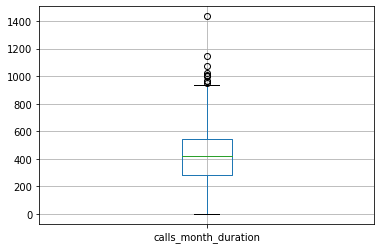

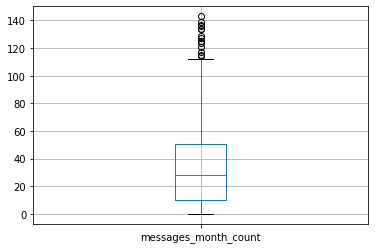

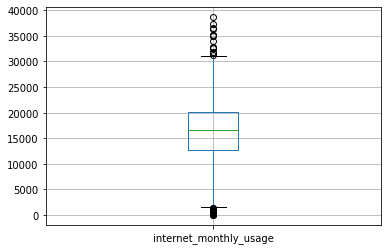

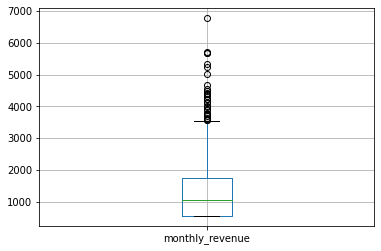

In [58]:
for column in ['calls_month_duration', 'messages_month_count','internet_monthly_usage', 'monthly_revenue']:
    plt.subplots(1)
    monthly_data_smart.boxplot(column)

В целом можно сказать, что да, есть значения, выходящие за полтора межквартильных размаха сверху, но слишком выбивающимися их назвать трудно.

Отдельно отметим, что по показателю месячной выручки по тарифу 'smart' достаточно большое количество выбросов, что может нам намекать на то, что данный тариф может приносить существенно большую выручку, чем абонентская плата.

Далее построим гистограммы для визуализации того, как используют звонки, сообщения, интернет абоненты тарифа smart, а также взглянем на распределение выручки в месяц.

Для этого создадим словарь, где ключами будут столбцы, а значениями - списки с названиями графиков, диапазоном значений и количеством корзин.

Длительность звонков в месяц, минут:
Медиана: 423
Среднее: 419
Ст. отклонение: 189
Дисперсия: 35844

Количество отправленных сообщений в месяц, шт.:
Медиана: 28
Среднее: 33
Ст. отклонение: 28
Дисперсия: 799

Объем потраченного интернет-трафика, мб:
Медиана: 16527
Среднее: 16230
Ст. отклонение: 5883
Дисперсия: 34613961

Средняя выручка с абонента, руб:
Медиана: 1039
Среднее: 1296
Ст. отклонение: 822
Дисперсия: 675105



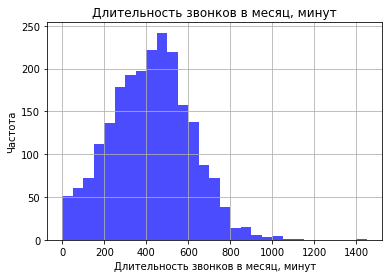

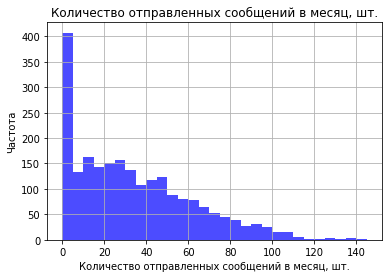

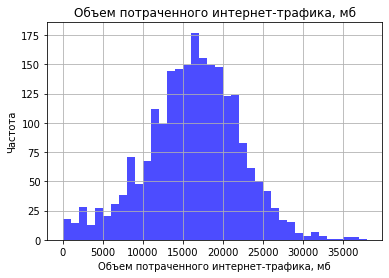

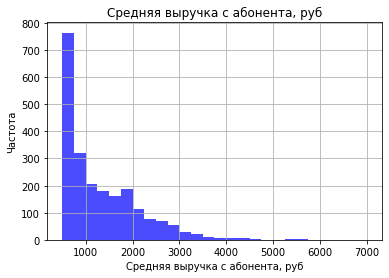

In [59]:
cols_for_viz_smart = {'calls_month_duration' : ['Длительность звонков в месяц, минут', (0, 1450), 29],
                'messages_month_count' : ['Количество отправленных сообщений в месяц, шт.', (0, 145), 29],
                'internet_monthly_usage' : ['Объем потраченного интернет-трафика, мб', (0, 38000), 38],
                'monthly_revenue' : ['Средняя выручка с абонента, руб', (500, 7000), 26]}

for col, name in cols_for_viz_smart.items():
    monthly_data_smart.plot(y=col, title=name[0], grid=True, kind='hist', color='b', legend=False, range=name[1], bins=name[2], alpha = 0.7)
    print(f'{name[0]}:\nМедиана: {monthly_data_smart[col].median():.0f}\nСреднее: {monthly_data_smart[col].mean():.0f}\nСт. отклонение: {np.sqrt(np.var(monthly_data_smart[col], ddof=1)):.0f}\nДисперсия: {np.var(monthly_data_smart[col],ddof=1):.0f}\n')
    plt.ylabel('Частота')
    plt.xlabel(name[0])

Итак, сначала рассмотрим первую гистограмму с длительностью звонков в течение месяца.

Из графика видно, что распределение длительности звонков в месяц в целом похоже на нормальное, но пик значений приходится на 500-550 минут.

Из расчетов видно, что в среднем пользователи тарифа smart совершают звонки на 419 минут в месяц, что ниже предоставленного лимита.

Интресно проанализировать какую долю составляли месяцы, в которых абоненты прибегали к дополнительным услугам.

In [60]:
print(f"Доля месяцев с дополнительными минутами: {len(monthly_data_smart.query('calls_month_duration > 500')) / len(monthly_data_smart['calls_month_duration']):.2%}")

Доля месяцев с дополнительными минутами: 33.92%


То есть, в трети месяцев абоненты пользовались дополнительными минутами.

Узнаем, сколько минут в среднем приходилось оплачивать.

In [61]:
print(f"Среднее превышение лимита абонентами, которым не хватало 500 минут: {monthly_data_smart.query('calls_month_duration > 500')['calls_month_duration'].mean() - 500:.0f}")

Среднее превышение лимита абонентами, которым не хватало 500 минут: 123


Значит, абонентам потребности в разговорах которых превышали лимит минут, нужно было еще около 2 часов звонков.

Далее взглянем на график с сообщениями.

Видно, что было очень большое количество месяцев, когда абоненты не отправляли никаких сообщений.

Но среднее значение отправленных сообщений - 28.

Также посмотрим, сколько людей прибегало к отправке сообщений сверх лимита и сколько сообщений такие люди отправляли выше включенного в плату значения.

In [62]:
print(f"Доля месяцев с дополнительными сообщениями: {len(monthly_data_smart.query('messages_month_count > 50')) / len(monthly_data_smart['messages_month_count']):.2%}")
print(f"Среднее превышение лимита абонентами, которым не хватало 50 сообщений: {monthly_data_smart.query('messages_month_count > 50')['messages_month_count'].mean() - 50:.0f}")

Доля месяцев с дополнительными сообщениями: 25.37%
Среднее превышение лимита абонентами, которым не хватало 50 сообщений: 23


В четверти месяцев абоненты выбивались за лимит сообщений, и в среднем им требовалось около 23 сообщений.

Далее посмотрим на гистограмму потраченного мегабайтов интернета.

Обращает на себя внимание, что распределение частоты этого параметра очень похоже на нормальное.

Расчетное среднее значение - 16200 мб, и на графике видно, что пик приходится на значения в диапазоне от 16000 до 17000 мб. Хвосты в целом укладываются в пределах среднего и трех сигм.

Посмотрим, в скольких месяцах абоненты выбились за лимит предоставленного трафика и солько трафика в среднем бралось дополнительно.

In [63]:
print(f"Доля месяцев с дополнительным интернет-трафиком: {len(monthly_data_smart.query('internet_monthly_usage > 15360')) / len(monthly_data_smart['internet_monthly_usage']):.2%}")
print(f"Среднее превышение лимита абонентами, которым не хватало 15 ГБ интернета: {monthly_data_smart.query('internet_monthly_usage > 15360')['internet_monthly_usage'].mean() - 15360:.0f}")

Доля месяцев с дополнительным интернет-трафиком: 58.70%
Среднее превышение лимита абонентами, которым не хватало 15 ГБ интернета: 4724


Здесь получились очень интересные данные.

Получается больше, чем в половине случаев пользователи тарифа smart выбивались из лимита включенного трафика, и в среднем им требовалось почти 5 гб интернета. 

Далее посмотрим на распределение выручки по месяцам.

Здесь видно, что стандартная абонентская плата в 550 рублей взималась примерно в трети месяцев.

Среднее значение выручки этого тарифа - около 1300 рублей, что более чем вдвое превышает абонентскую плату.

Посчитаем, сколько всего принес денег этот тариф.

In [64]:
print(f"Суммарная выручка от абонентов тарифа smart: {monthly_data_smart['monthly_revenue'].sum()} тыс. руб.")

Суммарная выручка от абонентов тарифа smart: 2880051 тыс. руб.


## Вывод 

Абоненты тарифа smart достаточно часто прибегают к дополнительным услугам сверх тарифного пакета - в трети случаев по звонкам, в четверти - по сообщениям и в более половине случаев по интернету.

Средняя выручка существенно (более чем вдвое) превышает абонентскую плату, составляя почти 1300 рублей, но обладает также значительным стандартным отклонением.

Вообще выглядит так, что такой тарифный план не слишком удобен для большинства абонентов, так как потребности в интернет-трафике у людей куда больше, чем предлагает тариф. И получается, что при превышении трафика на 2 ГБ (13%) абоненту приходится дополнительно платить примерно 75% абонентской платы.

Возможно, это негативно сказывается на пользовательском опыте, но, видимо, данных слишком мало, чтобы говорить о том, что есть серьезный отток абонентов. Всего 23 пользователя тарифа smart отказались от него.

## 3.2 Анализ абонентов тарифа ultra

Далее сделаем аналогинчые операции для абонентов тарифа ultra.

Создадим отдельный датафрейм с такими абонентами.

In [65]:
monthly_data_ultra = monthly_data.query('tariff == "ultra"')
monthly_data_ultra.head(15)

calls_month_count  calls_month_duration  messages_month_count  \
user_id month                                                                  
1000    5                     22                   159                    22   
        6                     43                   172                    60   
        7                     47                   340                    75   
        8                     52                   408                    81   
        9                     58                   466                    57   
        10                    57                   350                    73   
        11                    43                   338                    58   
        12                    46                   333                    70   
1003    8                     55                   380                    37   
        9                    134                   961                    91   
        10                   108                   855                    83   
        11                   115                   824                    94   
        12                   108                   802                    75   
1004    5                      9                    35                    95   
        6                     31                   171                   134   

               internet_monthly_usage tariff         city  monthly_revenue  
user_id month                                                               
1000    5                        2256  ultra    Краснодар             1950  
        6                       23257  ultra    Краснодар             1950  
        7                       14016  ultra    Краснодар             1950  
        8                       14070  ultra    Краснодар             1950  
        9                       14581  ultra    Краснодар             1950  
        10                      14717  ultra    Краснодар             1950  
        11                      14768  ultra    Краснодар             1950  
        12                       9827  ultra    Краснодар             1950  
1003    8                        8571  ultra       Москва             1950  
        9                       12479  ultra       Москва             1950  
        10                      14779  ultra       Москва             1950  
        11                      11368  ultra       Москва             1950  
        12                      10132  ultra       Москва             1950  
1004    5                       13415  ultra  Новокузнецк             1950  
        6                       17619  ultra  Новокузнецк             1950

Взглянем на информацию о таблице.

In [66]:
monthly_data_ultra.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 951 entries, (1000, 5) to (1495, 12)
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   calls_month_count       951 non-null    int64 
 1   calls_month_duration    951 non-null    int64 
 2   messages_month_count    951 non-null    int64 
 3   internet_monthly_usage  951 non-null    int64 
 4   tariff                  951 non-null    object
 5   city                    951 non-null    object
 6   monthly_revenue         951 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 79.2+ KB


In [67]:
monthly_data_ultra.describe()

,calls_month_count,calls_month_duration,messages_month_count,internet_monthly_usage,monthly_revenue
count,951.000000,951.000000,951.000000,951.000000,951.000000
mean,76.016824,545.451104,49.033649,19480.544690,2071.924290
std,42.403348,306.925754,46.890656,10135.971146,382.106872
min,1.000000,0.000000,0.000000,0.000000,1950.000000
25%,43.000000,310.000000,5.000000,11633.500000,1950.000000
50%,75.000000,528.000000,39.000000,19374.000000,1950.000000
75%,105.000000,756.500000,79.000000,26857.500000,1950.000000
max,244.000000,1673.000000,224.000000,49789.000000,4800.000000


Итак, у нас есть 951 абоненто-месяц тарифа ultra, который мы можем проанализировать. Эта выборка более чем в 2 раза меньше выборки абонентов тарифа smart.

Построим боксплоты, чтобы взглянуть на редкие значения.

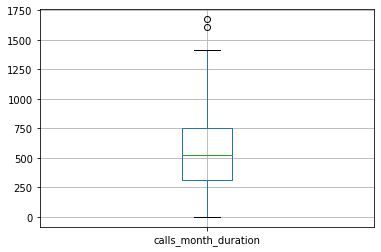

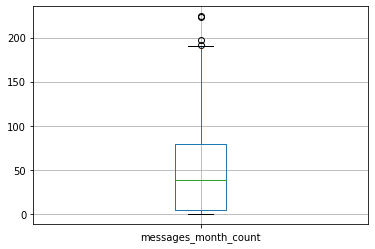

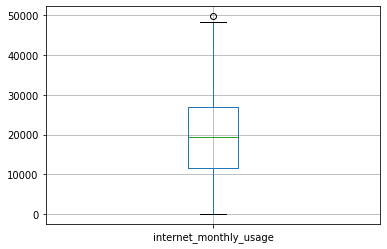

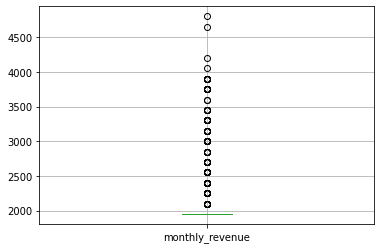

In [68]:
for column in ['calls_month_duration', 'messages_month_count','internet_monthly_usage', 'monthly_revenue']:
    plt.subplots(1)
    monthly_data_ultra.boxplot(column)

Как видим, в тарифе ultra значений, выходящих за полтора межквартильных интервала очень мало.

Обращает на себя внимание последний график с месячной выручкой - видно, что выручка от большинства абонентов составляет абоненсткую плату, и есть только около двух десятков месяцев, когда выручка превышала 1950 рублей.

Далее построим гистограммы и посчитаем средние, дисперсии и стандартное отклонение.

Длительность звонков в месяц, минут:
Медиана: 528
Среднее: 545
Ст. отклонение: 307
Дисперсия: 94203

Количество отправленных сообщений в месяц, шт.:
Медиана: 39
Среднее: 49
Ст. отклонение: 47
Дисперсия: 2199

Объем потраченного интернет-трафика, мб:
Медиана: 19374
Среднее: 19481
Ст. отклонение: 10136
Дисперсия: 102737911

Средняя выручка с абонента, руб:
Медиана: 1950
Среднее: 2072
Ст. отклонение: 382
Дисперсия: 146006



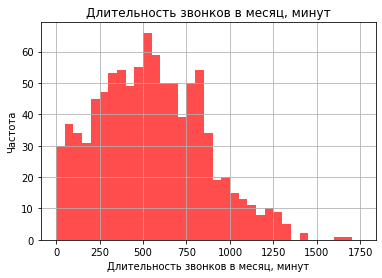

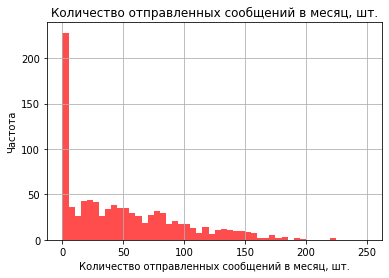

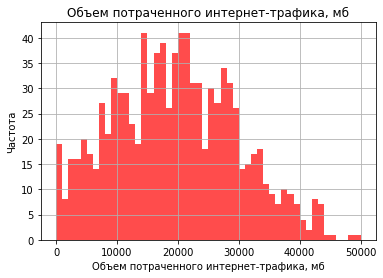

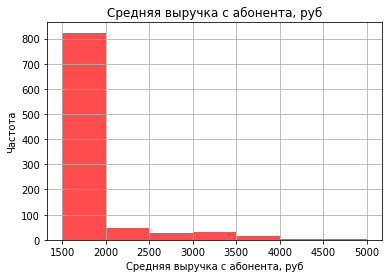

In [69]:
cols_for_viz_ultra = {'calls_month_duration' : ['Длительность звонков в месяц, минут', (0, 1750), 35],
                'messages_month_count' : ['Количество отправленных сообщений в месяц, шт.', (0, 250), 50],
                'internet_monthly_usage' : ['Объем потраченного интернет-трафика, мб', (0, 50000), 50],
                'monthly_revenue' : ['Средняя выручка с абонента, руб', (1500, 5000), 7]}

for col, name in cols_for_viz_ultra.items():
    monthly_data_ultra.plot(y=col, title=name[0], grid=True, kind='hist', color='r', legend=False, range=name[1], bins=name[2], alpha = 0.7)
    print(f'{name[0]}:\nМедиана: {monthly_data_ultra[col].median():.0f}\nСреднее: {monthly_data_ultra[col].mean():.0f}\nСт. отклонение: {np.sqrt(np.var(monthly_data_ultra[col], ddof=1)):.0f}\nДисперсия: {np.var(monthly_data_ultra[col], ddof=1):.0f}\n')
    plt.ylabel('Частота')
    plt.xlabel(name[0])

Итак, посмотрим на гистограмму с распределением длительности звонков.

В целом можно сказать, что оно похоже на нормальное. Пик значений приходится на длительность от 500 до 550 минут.

Расчетное среднее ultra также лежит в этом диапазоне и составляет 545 минут, что достаточно существенно превышает среднюю продолжительность звонков абонентов smart.

По длительности звонков никто из абонентов не выбился из лимита, хвосты в целом уложились в три сигмы.

Далее взглянем на сообщения - в выборке присутствовало достаточно большое количество месяцев, когда абоненты не отправляли сообщения.

Среднее значение составило 50, что не то, что не превышает лимит, а соответствует лимиту из другого тарифного плана.


Распределение потраченного интернет-трафика также похоже на нормальное. Пик значений пришелся на 20-22 ГБ. Расчетное среднее - 19.5 ГБ. Интересно, что стандартное отклонение составляет почти половину от среднего, в то время как у абонентов smart оно составляло около трети.

По этому показателю было превышение тарифного лимита, посмотрим, сколько было таких месяцев.

In [70]:
print(f"Доля месяцев с дополнительным интернет-трафиком: {len(monthly_data_ultra.query('internet_monthly_usage > 30720')) / len(monthly_data_ultra['internet_monthly_usage']):.2%}")
print(f"Среднее превышение лимита абонентами, которым не хватало 30 ГБ интернета: {monthly_data_ultra.query('internet_monthly_usage > 30720')['internet_monthly_usage'].mean() - 30720:.0f}")

Доля месяцев с дополнительным интернет-трафиком: 13.46%
Среднее превышение лимита абонентами, которым не хватало 30 ГБ интернета: 5654


Из-за того, что было только 13.5% месяцев, когда пользователи выходили за лимит услуг, среднее значение месячной выручки с абонента достаточно устойчиво и составляет 2072 рубля со стандартным отклонением в 382 рубля.

Посчитаем, сколько выручки принесли за период абоненты этого тарифа.

In [71]:
print(f"Суммарная выручка от абонентов тарифа ultra: {monthly_data_ultra['monthly_revenue'].sum()} тыс. руб.")

Суммарная выручка от абонентов тарифа ultra: 1970400 тыс. руб.


### Вывод 

Из-за того, что лимиты по сообщениям и минутам звонков очень высокие, абоненты ultra не приближаются к пороговым значениям.

Лимит интернет-трафика также высок, его превышали только в 13.5% случаев.

Выручка от тарифа ultra стабильна и почти всегда равна абонентской плате.

Суммарная же выручка тарифа ultra составляет примерно две трети от выручки абонентов smart, при том, что абонентов ultra более чем в 2 раза меньше.

Напоследок выедем сводную таблицу со средними показателями двух тарифных групп.

In [72]:
monthly_data_tariffs = monthly_data.pivot_table(index = ['tariff'])
monthly_data_tariffs

,calls_month_count,calls_month_duration,internet_monthly_usage,messages_month_count,monthly_revenue
tariff,,,,,
smart,58.621233,419.062978,16230.166892,33.396311,1295.569501
ultra,76.016824,545.451104,19480.544690,49.033649,2071.924290


## Шаг 4. Проверка гипотез

### 4.1 Сравнение средней выручки пользователей тарифов smart и ultra

Итак, нам необходимо сравнить среднюю выручку пользователей тарифов smart и ultra.

В данном случае мы будем формулировать гипотезу о равенстве среднего двух генеральных совокупностей.

Соответственно, первой генеральной совокупностью для нас будут абоненты тарифа smart, вторая генеральная совокупность - абоненты тарифа ultra.

Соответственно, нам нужно провести тест для того, чтобы можно было сделать вывод о том, случайны ли отличия средних двух выборок - абонентов smart и ultra.

Таким образом, нулевая гипотеза Н0 для нас состоит в том, что средние выручки абонентов тарифа smart и ultra равны.

Следовательно, альтернативная гипотеза H1 - средние выручки абонентов не равны.

Чтобы проверить эту гипотезу, обратимся к тесту scipy.stats.ttest_ind.

Уровень значимости выберем в 5%.

На наш взгляд, есть основания полагать, что дисперсии выборок разные, а значит установим параметр  "equal_var = False". В целом мы это вроде бы видели, когда рассчитывали их в пункте 3, где было видно, что средняя выручка абонентов ultra - более устойчивая величина.

Итак, передадим методу два массива, содержащие выборки.

In [73]:
alpha_level = 0.05
results_tariffs = ( 
    st.ttest_ind(monthly_data_smart['monthly_revenue'],
                 monthly_data_ultra['monthly_revenue'],equal_var = False )  
)

Итак, выведем на экран p-значение, и сравним его с уровнем значимости.

In [74]:
print(f"p-значение: {results_tariffs.pvalue}")
if (results_tariffs.pvalue < alpha_level): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.8405224159827356e-241
Отвергаем нулевую гипотезу


### Вывод 

Итак, полученное значение p-value говорит о том, что наблюдаемое различие в средних выручках абонентов из двух тарифных групп может быть случайным с ничтожнейшей вероятностью. Следовательно, различие между средними выручками значимо. Мы отвергаем нулевую гипотезу, средние выручки абонентов разных тарифов не равны.

### 4.2 Сравнение средней выручки пользователей из Москвы и других регионов

На этом этапе нам необходимо сравнить среднюю выручку абонентов из Москвы со средней выручкой абонентов из регионов.

В данном случае мы также будем формулировать гипотезу о равенстве средних двух генеральных совокупностей.

Соответственно, первой генеральной совокупностью для нас будут абоненты из Москвы, вторая генеральная совокупность - абоненты не из Москвы.

Соответственно, нам нужно провести тест для того, чтобы можно было сделать вывод о том, случайны ли отличия средних этих двух выборок - абонентов из Москвы и абонентов из регионов.

Таким образом, нулевая гипотеза Н0 для нас состоит в том, что средние выручки абонентов из Москвы и из регионов равны.

Следовательно, альтернативная гипотеза H1 - средние выручки абонентов не равны.

Чтобы проверить эту гипотезу, обратимся к тесту scipy.stats.ttest_ind.

Уровень значимости оставим на 5%.

На наш взгляд, здесь нет оснований полагать, что дисперсии выборок разные, так как и в Москве и в регионах абоненты обоих тарифов. Значит установим параметр  "equal_var = True".

Создадим необходимые нам массивы.

In [75]:
moscow = monthly_data.query('city == "Москва"')
regions = monthly_data.query('city != "Москва"')

Передадим методу два массива, содержащие выборки.

In [76]:
results_cities = st.ttest_ind(moscow['monthly_revenue'],regions['monthly_revenue'])  

Итак, выведем на экран p-значение, и сравним его с уровнем значимости.

In [77]:
print(f"p-значение: {results_cities.pvalue}")
if (results_cities.pvalue < alpha_level): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4516335152984994
Не получилось отвергнуть нулевую гипотезу


### Вывод 

Полученное значение p-value говорит о том, что хотя средняя выручка абонентов в Москве и регионах отличается, с вероятностью около 45% такое или большее различие можно получить случайно.

Это слишком большая вероятность, чтобы делать выводы о значимом различии между средними выручками двух групп абонентов. Мы не отвергаем нулевую гипотезу, значит, продолжаем полагать, что средняя выручка москвичей и абонентов из регионов не отличается.

## Шаг 5. Общий вывод

Итак, мы проанализировали выборку 500 абонентов мобильного оператора.

Для проведения анализа мы использовали сводные таблицы, в которых группировали данные по абонентам и по месяцам, получив данные об отправленных сообщениях, минутах разговора, использованном интернет-трафике и средней выручке от абонента в месяц.

После этого мы разбили данные на две части и отдельно проанализировали абонентов тарифа smart и абонентов тарифа ultra.

Оказалось, что абоненты smart, у которых ограниченные лимиты по включенному объему услуг в абонентсвую плату, очень часто прибегают к оплате дополнительных услуг, особенно интернет-трафика. Возможно, это создает для них неудобства.

Напротив, у абонентов ultra лимиты по сообщениям и звонкам существенно превышают их потребности, а к дополнительному интернету они прибегают гораздо реже.

Средняя выручка от абонентов ultra составляет 2070 рублей, а абонентов smart  - около 1300 рублей (что существенно превышает абонентскую плату).

Возможно, "Мегалайн" стоит задуматься о том, чтобы увеличить объем услуг включенных в абонентскую плату и повысить ее.

Также мы проверяли гипотезы о равенстве средней выручки.

Первая проверка касалась того, равны ли средние выручки по двум тарифным планам. Проведенный нами статистический тест, показал, что мы должны отвергнуть нулевую гипотезу о равенстве выручек.

Вторая проверка касалась равенства средних выручек от абонентов из Москвы и регионов. Тест продемонстрировал, что у нас недостаточно аргументов, чтобы отвергнуть нулевую гипотезу, средние выручки абонентов из Москвы и регионов равны.